# Transformers-based Classification (Multi Label)

This notebook implements transformer-based models to classify research papers into categories based on their titles and abstracts. It uses the combined dataset of existing categorized papers and new papers for training and evaluation.


In [1]:
import torch
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from ast import literal_eval
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy

## Data Loading & Preprocessing


In [ ]:
# Load the existing categorized papers (after post-processing)
df_existing = pd.read_csv("../data/combined_data_original.csv")
df_existing.head(2)

,title,category,link,authors,year,abstract
0,A Framework to Generate Neurosymbolic PDDL-com...,['plan-generation'],https://arxiv.org/abs/2303.00438,"Capitanelli, Alessio and Mastrogiovanni, Fulvio",2023,Symbolic task planning is a widely used approa...
1,A Prefrontal Cortex-inspired Architecture for ...,['brain-inspired-planning'],https://arxiv.org/abs/2310.00194,"Webb, Taylor and Mondal, Shanka Subhra and Wan...",2023,Large language models (LLMs) demonstrate impre...


In [ ]:
# Load the new papers (CSV format)
df_new = pd.read_csv("../data/newer_all_arxiv_papers_20240925_171114.csv")
df_new.head(2)

,Title,Authors,Published Date,Abstract,URL,Categories,Comments
0,LASP: Surveying the State-of-the-Art in Large ...,"Haoming Li, Zhaoliang Chen, Jonathan Zhang, Fe...",2024-09-03,Effective planning is essential for the succes...,http://arxiv.org/abs/2409.01806v1,"Plan Generation, Goal Decomposition",Survey paper
1,Planetarium: A Rigorous Benchmark for Translat...,"Max Zuo, Francisco Piedrahita Velez, Xiaochen ...",2024-07-03,Many recent works have explored using language...,http://arxiv.org/abs/2407.03321v1,Language Translation,NaN


In [4]:
# Pre-processing: remove row 14, 49, 50
df_new.drop(df_new.index[[11, 48, 49]], inplace=True)
df_new.reset_index(drop=True, inplace=True)

In [ ]:
# Function to standardize category format
def standardize_categories(categories):
    if isinstance(categories, str):
        # Handle string representation of lists
        if categories.startswith("["):
            categories = literal_eval(categories)
        # Handle single string
        elif categories == "-":
            return []
        else:
            # Split by comma and clean up
            categories = [cat.strip() for cat in categories.split(",")]

    # Standardize category names
    standardized = []
    for cat in categories:
        # Convert to lowercase and replace spaces with hyphens
        cat = cat.lower().replace(" ", "-")
        # Remove any special characters if needed
        standardized.append(cat)

    return standardized

In [ ]:
# Combine title and abstract for feature extraction
df_existing["text"] = df_existing["title"] + " " + df_existing["abstract"]
df_new["text"] = df_new["Title"] + " " + df_new["Abstract"]

In [7]:
df_existing.category = df_existing.category.apply(standardize_categories)
df_new.Categories = df_new.Categories.apply(standardize_categories)

In [ ]:
def generate_distribution(df, cat, title):
    # Plot the distribution of categories
    plt.figure(figsize=(6, 3))
    sns.countplot(y=cat, data=df, order=df[cat].value_counts().index)
    plt.title(title)
    plt.xlabel("Count")
    plt.ylabel("Category")
    plt.show()

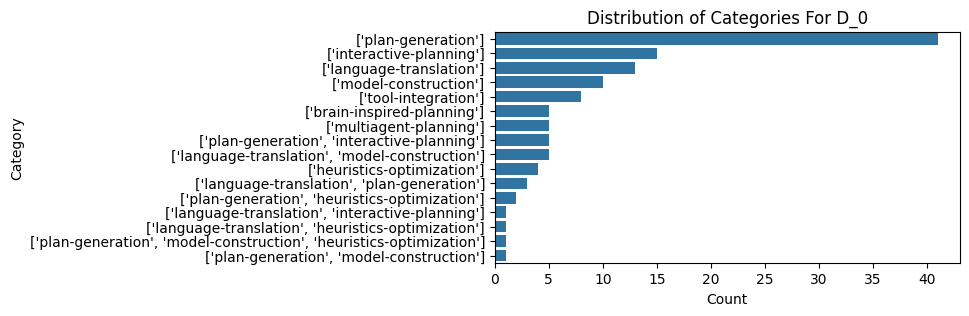

In [ ]:
generate_distribution(df_existing, "category", "Distribution of Categories For D_0")

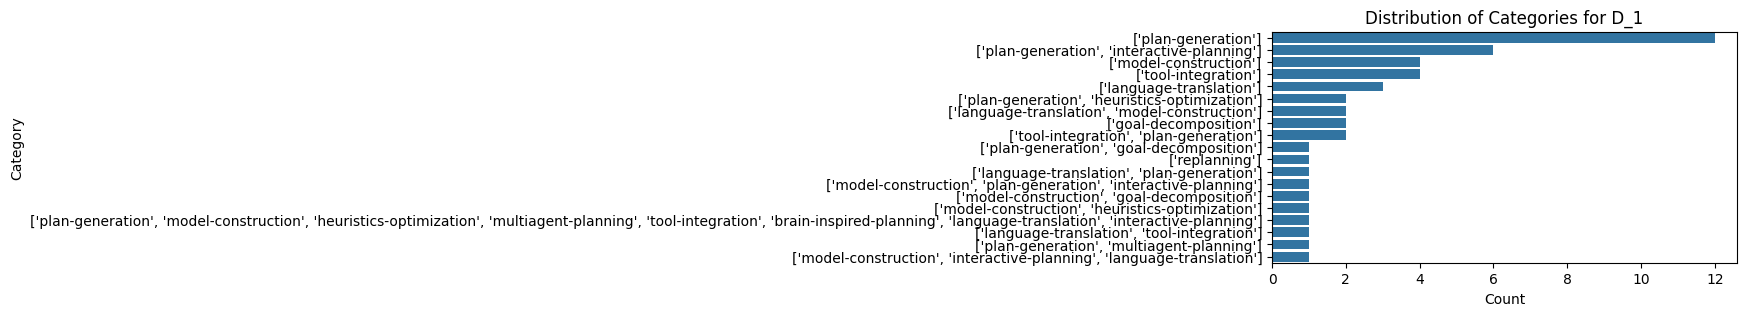

In [ ]:
generate_distribution(df_new, "Categories", "Distribution of Categories for D_1")

<br>


## Create Features


In [ ]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")

X_old = vectorizer.fit_transform(df_existing["text"])
X_new = vectorizer.transform(df_new["text"])

In [ ]:
# Fit MLB only on training categories
mlb = MultiLabelBinarizer()
y_old = mlb.fit_transform(df_existing["category"])

In [ ]:
# Transform new data using only the categories from training
y_new = mlb.transform(df_new["Categories"])

/Users/nitingupta/miniconda3/envs/lit-cat/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['goal-decomposition', 'replanning'] will be ignored
  warnings.warn(


In [14]:
# Convert sparse matrix to array for iterative stratification
X_old_array = X_old.toarray()

In [15]:
# Split old data into train and test sets
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [16]:
for train_idx, test_idx in msss.split(X_old_array, y_old):
    X_train = X_old[train_idx]
    X_test = X_old[test_idx]
    y_train = y_old[train_idx]
    y_test = y_old[test_idx]

In [17]:
# Print some information about the split
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (96, 2974)
Test set shape: (24, 2974)


In [ ]:
# Print distribution information
def print_label_distribution(y, set_name):
    label_counts = y.sum(axis=0)
    print(f"\nLabel distribution in {set_name}:")
    for i, count in enumerate(label_counts):
        if count > 0:  # Only print categories that appear
            print(f"{mlb.classes_[i]}: {count}")


print_label_distribution(y_train, "training set")
print_label_distribution(y_test, "test set")


Label distribution in training set:
brain-inspired-planning: 4
heuristics-optimization: 6
interactive-planning: 17
language-translation: 18
model-construction: 14
multiagent-planning: 4
plan-generation: 42
tool-integration: 6

Label distribution in test set:
brain-inspired-planning: 1
heuristics-optimization: 2
interactive-planning: 4
language-translation: 5
model-construction: 3
multiagent-planning: 1
plan-generation: 11
tool-integration: 2


## Train, Evaluate, and Test Model


In [ ]:
def set_seed(seed):
    """Set all seeds to make results reproducible (deterministic mode).
    When seed is a false-y value or not supplied, disables deterministic mode."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


seed = 472
set_seed(seed)

In [ ]:
class PaperDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
        }

In [ ]:
class TransformerClassifier:
    def __init__(
        self,
        model_name,
        num_labels,
        device="cuda" if torch.cuda.is_available() else "cpu",
    ):
        self.device = device
        self.model_name = model_name
        self.num_labels = num_labels

        # Initialize tokenizer and model
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.base_model = AutoModel.from_pretrained(model_name).to(device)

        # Freeze the transformer parameters
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Add classification head
        self.classifier = torch.nn.Linear(
            self.base_model.config.hidden_size, num_labels
        ).to(device)

    def get_embeddings(self, texts, batch_size=8):
        dataset = PaperDataset(texts, self.tokenizer)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        all_embeddings = []

        self.base_model.eval()
        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Getting embeddings"):
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)

                outputs = self.base_model(
                    input_ids=input_ids, attention_mask=attention_mask
                )

                # Use [CLS] token embedding
                embeddings = outputs.last_hidden_state[:, 0, :]
                all_embeddings.append(embeddings.cpu())

        return torch.cat(all_embeddings, dim=0)

    def predict(self, texts, threshold=0.5):
        embeddings = self.get_embeddings(texts)
        with torch.no_grad():
            logits = self.classifier(embeddings.to(self.device))
            predictions = torch.sigmoid(logits) > threshold
        return predictions.cpu().numpy()

In [ ]:
def evaluate_models(X_test, y_test, df_new, mlb):
    # Initialize models
    model_configs = {
        "BERT": "bert-base-uncased",
        "SciBERT": "allenai/scibert_scivocab_uncased",
    }

    results = {}

    # Convert sparse matrix to dense if necessary
    if scipy.sparse.issparse(X_test):
        X_test = X_test.toarray()

    for model_name, model_path in model_configs.items():
        print(f"\nEvaluating {model_name}...")

        # Initialize classifier
        classifier = TransformerClassifier(model_path, num_labels=len(mlb.classes_))

        # Get predictions for test set
        y_pred_test = classifier.predict(X_test)

        # Get predictions for new data
        y_pred_new = classifier.predict(df_new["text"])

        results[model_name] = {
            "test_report": classification_report(
                y_test,
                y_pred_test,
                target_names=mlb.classes_,
                zero_division=0,
                digits=3,
            ),
            "predictions": y_pred_new,
        }

        # Convert predictions back to categories
        df_new[f"{model_name}_predicted"] = mlb.inverse_transform(y_pred_new)

    return results

In [23]:
df_new.text

0     LASP: Surveying the State-of-the-Art in Large ...
1     Planetarium: A Rigorous Benchmark for Translat...
2     Automated radiotherapy treatment planning guid...
3     RePrompt: Planning by Automatic Prompt Enginee...
4     DAG-Plan: Generating Directed Acyclic Dependen...
5     CLMASP: Coupling Large Language Models with An...
6     GameVLM: A Decision-making Framework for Robot...
7     LLM+Reasoning+Planning for supporting incomple...
8     NL2Plan: Robust LLM-Driven Planning from Minim...
9     Generating consistent PDDL domains with Large ...
10    The Case for Developing a Foundation Model for...
11    DELTA: Decomposed Efficient Long-Term Robot Ta...
12    A Survey of Optimization-based Task and Motion...
13    Large Language Models as Planning Domain Gener...
14    TwoStep: Multi-agent Task Planning using Class...
15    LLM3:Large Language Model-based Task and Motio...
16    Beyond A*: Better Planning with Transformers v...
17    AutoGPT+P: Affordance-based Task Planning 

In [24]:
# Now evaluate the models using the test set we created earlier
results = evaluate_models(X_test, y_test, df_new, mlb)


Evaluating BERT...


/Users/nitingupta/miniconda3/envs/lit-cat/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Getting embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.69s/it]



Evaluating SciBERT...


/Users/nitingupta/miniconda3/envs/lit-cat/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Getting embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.93s/it]


In [ ]:
# Print results
for model_name, model_data in results.items():
    print(f"\nResults for {model_name} on test set:")
    print(model_data["test_report"])

    print(f"\nPerformance on new data for {model_name}:")
    print(
        classification_report(
            y_new,
            model_data["predictions"],
            target_names=mlb.classes_,
            zero_division=0,
            digits=3,
        )
    )

    print("-" * 30)


Results for BERT on test set:
                         precision    recall  f1-score   support

brain-inspired-planning      0.042     1.000     0.080         1
heuristics-optimization      0.083     1.000     0.154         2
   interactive-planning      0.000     0.000     0.000         4
   language-translation      0.208     1.000     0.345         5
     model-construction      0.136     1.000     0.240         3
    multiagent-planning      0.000     0.000     0.000         1
        plan-generation      0.000     0.000     0.000        11
       tool-integration      0.000     0.000     0.000         2

              micro avg      0.117     0.379     0.179        29
              macro avg      0.059     0.500     0.102        29
           weighted avg      0.057     0.379     0.098        29
            samples avg      0.118     0.375     0.176        29


Performance on new data for BERT:
                         precision    recall  f1-score   support

brain-inspired-plann

In [26]:
df_new.columns

Index(['Title', 'Authors', 'Published Date', 'Abstract', 'URL', 'Categories',
       'Comments', 'text', 'BERT_predicted', 'SciBERT_predicted'],
      dtype='object')

In [ ]:
# Save results to the same CSV
df_new.to_csv("../outputs/tf_multi_final.csv", index=False)